# **3. Adversarial Example Generation**

머신러닝은 계속 빠르게 발전 중인데 보안성과 경고성(robustness)를 간과함, 특히 모델을 속이려는 공격자(adverary)가 존재할때 그 중요성은 더 커짐

사람 눈에 보이지 않을 정도의 아주 미세한 이미지 노이즈만 추가해도 모델의 성능이 완전히 달라질 수 있음

여기서는 MNIST 숫자 분류기를 대상으로 가장 대표적이고 유명한 공격 방법 중 하나인 FGSM(Fast Gradient Sign Method)를 이용해 모델을 속여 볼거임

Adversarial attack은 종류가 매우 다양하고 공격자의 목표와 지식 수준에 따라 구분 할 수 있음

공격자의 지식 수준

- 화이트 박스 : 모델의 아키텍처, 입력, 출력, 가중치까지 모든 정보에 접근 가능
- 블랙 박스 : 모델의 입력과 출력만 볼 수 있고 내부 구조는 전혀 모름

공격자의 목표

- 일반 오분류(misclassification) : 결과가 틀리기만 하면 됨, 어떤 클래스가 되든 상관없음
- 출발/목표 클래스 오분류(source/target misclassification): 예를들어 7을 1로 만들고 싶다 와 같이 특정 출발 클래스가 특정 목표 클래스로 분리되도록 유도

FGSM(Fast Gradient Sign Method)

FGSM은 가장 오래되고 유명한 적대적 공격 기법중 하나로 신경망이 학습하는 방식을 역으로 이용해서 모델을 공격하는 거임

일반적으로 신경망은 loss 값을 줄이기 위해 가중치를 업데이트함

반면 FGSM은 입력 이미지 자체를 조작해서 loss를 최대화 시킴

즉 입력 데이터에 대한 손실의 gradient를 계산해서 그 방향으로 입력 이미지를 조금만 변경함으로써 모델을 혼란스럽게 하는거임

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Implementation

여기서 사용할 입력값 (parameters)은 총 3가지
1. epsilons : 공격 강도를 조절하는 리스트

  - epsilon 은 입력 이미지에 얼마나 큰 노이즈 (perturbation)을 줄것인지를 의미하는  값

  - 0을 반드시 포함 해야함 -> 공격 없이 순수한 원본 성능 평가용

  - 데이터가 [0, 1] 범위이기 때문에 epsilon은 1을 넘으면 안됨

2. pretrained_model : 사전 학습된 모델 경로

3. 무작위성 제어를 위해 랜덤 시드 고정

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = '/content/drive/MyDrive/학부연구생/Pytorch - Image and Video/lenet_mnist_model.pth'

torch.manual_seed(42)

# Model Under Attack

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1) # 입력 1채널, 출력 32 채널, 3 x 3 커널, stride = 1
    self.conv2 = nn.Conv2d(32, 64, 3, 1) # 32채널 -> 64채널
    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),

    ])),
    batch_size = 1, shuffle = True)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f'Using {device} device')

model = Net().to(device)

model.load_state_dict(torch.load(pretrained_model, map_location=device, weights_only=True))

model.eval()

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.2MB/s]


Using cuda device


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

# FGSM Attack

In [ ]:
def fgsm_attack(image, epsilon, data_grad): # (원본 입력 이미지, 얼마나 강하게 교란할지, 입력이미지에 대한 손실 함수의 gradient)
  sign_data_grad = data_grad.sign() # gradient 방향 추출, 가장 빠르게 loss를 증가시키는 방향을 계산
  perturbed_image = image + epsilon * sign_data_grad # 이미지에 약간 교란을 추가
  pertirbed_iage = torch.clamp(perturbed_image, 0, 1) # 픽셀 값이 0~1 범위를 넘지 않도록 잘라냄
  return perturbed_image

def denorm(batch, mean=[0.1307], std=[0.3081]): # 정규화 해제 함수
  '''
  batch를 원래 스케일로 변환
  Args :
    batch(torch.Tensor) : 정규화된 텐서 배치(batch)
    mean(torch.Tensor or list) : 정규화시 사용했던 평균
    std(torch.Tensor or list) : 정규화시 사용했던 표준편차
  Returns:
    torch.Tensor : 정규화가 적용되지 않은 batch
  '''
  if isinstance(mean, list):
    mean = torch.tensor(mean).to(device)
  if isinstance(std, list):
    std = torch.tensor(std).to(device)

  # 채널에 맞게 shape을 브로드캐스팅 할 수 있도록 reshape
  return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

# Testing Function

In [ ]:
def test(model, device, test_loader, epsilon): #
  correct = 0 # 올바르게 분류된 샘플 수
  adv_examples = []

  # 테스트 셋의 모든 예제에 대해 루프
  for data, target in test_loader:

    # 디바이스에 데이터와 라벨 값을 보냄
    data, target = data.to(device), target.to(device)

    # gradient 추적, 공격에서 중요한 부분
    data.requires_grad = True

    # 데이터를 모델에 통과
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스를 예측값으로

    if init_pred.item() != target.item(): # 원래부터 예측이 틀렸으면 공격을 스킵함
      continue

    # 손실 계산 + 역전파 수행
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    # 정규화 해제 -> FGSM 공격 수행 -> 다시 정규화
    data_denorm = denorm(data)
    perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
    perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

    output = model(perturbed_data_normalized) # 다시 모델에 넣어서 예측값 확률 계산
    final_pred = output.max(1, keepdim=True)[1] # 최종 예측

    # 성공 여부 체크 및 예제 저장
    if final_pred.item() == target.item(): # 공격에도 예측이 맞았는가?
      correct += 1
      if epsilon == 0 and len(adv_examples) < 5: # epsilon == 0 인건 공격없는 원본예제 5개 까지 저장
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
    else: # epsilon 값 있는 거 5개 까지 저장
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

  # epsilon 값에 따른 모델의 정확도 계산
  final_acc = correct / float(len(test_loader))
  print(f"epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

  return final_acc, adv_examples

# Run Attack

In [ ]:
accuracies = [] # 각 epsilon에 대한 정확도 기록용 리스트
examples = [] # 각 epsilon에 저장한 공격 성공한 이미지 샘플들

for eps in epsilons: # epsilon 값에 따라 반복 실행
  acc, ex = test(model, device, test_loader, eps)
  accuracies.append(acc)
  examples.append(ex)

epsilon: 0	Test Accuracy = 9912 / 10000 = 0.9912
epsilon: 0.05	Test Accuracy = 9271 / 10000 = 0.9271
epsilon: 0.1	Test Accuracy = 7176 / 10000 = 0.7176
epsilon: 0.15	Test Accuracy = 4360 / 10000 = 0.436
epsilon: 0.2	Test Accuracy = 2145 / 10000 = 0.2145
epsilon: 0.25	Test Accuracy = 1110 / 10000 = 0.111
epsilon: 0.3	Test Accuracy = 660 / 10000 = 0.066


# Results

공격 강도가 증가함에 따라 모델 accuracy가 떨어지는 곡선이 나타나게 됨

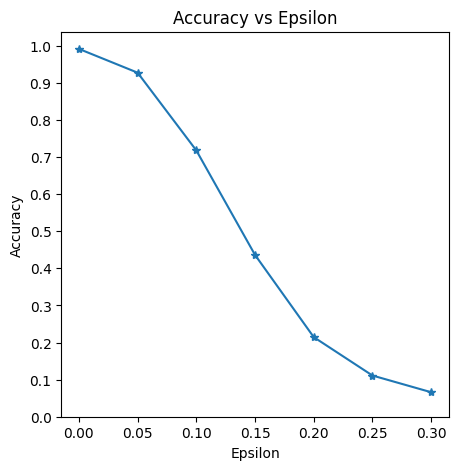

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

# Sample Adversarial Examples

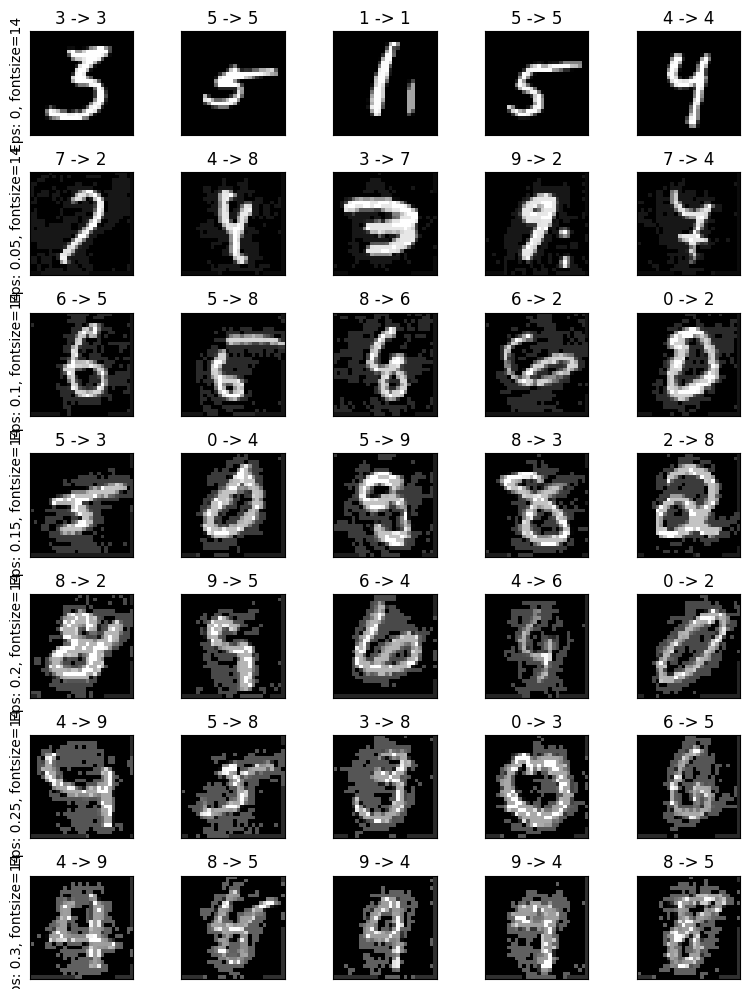

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))

# 모든 epsilon값에 대해 반복
for i in range(len(epsilons)):
  # 해당 epsilon에서 저장된 예제들 반복
  for j in range(len(examples[i])):
    cnt += 1
    plt.subplot(len(epsilons),len(examples[0]),cnt)
    plt.xticks([], [])
    plt.yticks([], [])

    # 맨 왼쪽 열에 epsilon 라벨 달기
    if j == 0:
      plt.ylabel(f"Eps: {epsilons[i]}, fontsize=14")

    # 예제 이미지 가져와서 출력
    orig,adv, ex = examples[i][j]
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap='gray')
plt.tight_layout()
plt.show()